In [201]:
%pylab inline
import os
import time
import pandas as pd
from shutil import copyfile, rmtree
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import optimizers
import scipy.io
from PIL import Image
from sklearn import metrics, preprocessing

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

# 1) Get data

Gather our files paths

In [3]:
# Get local path
local_path = os.getcwd()
pictures_path = local_path + '/data/images/'

In [4]:
# List images folders
breeds_folders = [local_path + "/data/images/" + file_name for file_name in os.listdir(local_path + "/data/images") if os.path.isdir(local_path + "/data/images/" + file_name)]

In [174]:
# List breeds id and name
breeds_id = [breed_path.split("/")[-1].split("-")[0] for breed_path in breeds_folders]
breeds_name = ["-".join(breed_path.split("/")[-1].split("-")[1:]) for breed_path in breeds_folders]
breed_dict = dict(zip(breeds_id, breeds_name))
reverse_breed_dict = dict(zip(breeds_name, breeds_id))
n_breeds = len(breeds_name)

Use train and test sets provided with data

In [6]:
train_mat = scipy.io.loadmat(local_path + '/data/lists/train_list.mat')
test_mat = scipy.io.loadmat(local_path + '/data/lists/test_list.mat')

Convert matlab matrix to pandas dataframe

In [72]:
# For train set
train_df = pd.DataFrame(train_mat['labels'], columns=['label'])
train_df['file'] = [str(file_name[0].tolist()[0]) for file_name in train_mat['file_list']]
train_df['breed_id'] = train_df.file.apply(lambda x: x.split("/")[0].split("-")[0])
train_df['breed_name'] = train_df.breed_id.apply(lambda x: breed_dict[x])
train_df.label = train_df.label.apply(lambda x: x - 1)

# For test set
test_df = pd.DataFrame(test_mat['labels'], columns=['label'])
test_df['file'] = [str(file_name[0].tolist()[0]) for file_name in test_mat['file_list']]
test_df['breed_id'] = test_df.file.apply(lambda x: x.split("/")[0].split("-")[0])
test_df['breed_name'] = test_df.breed_id.apply(lambda x: breed_dict[x])
test_df.label = test_df.label.apply(lambda x: x - 1)

In [86]:
# Get label-names dict
breed_labels_df = train_df.loc[:, ['label', 'breed_name']].drop_duplicates()
breed_label_dict = dict(zip(breed_labels_df.label.values, breed_labels_df.breed_name.values))
label_breed_dict = dict([[v,k] for k,v in breed_label_dict.items()])

In [74]:
train_df.sample(5)

,label,file,breed_id,breed_name
3788,37,n02095314-wire-haired_fox_terrier/n02095314_18...,n02095314,wire-haired_fox_terrier
3426,34,n02094114-Norfolk_terrier/n02094114_2819.jpg,n02094114,Norfolk_terrier
8438,84,n02106662-German_shepherd/n02106662_18268.jpg,n02106662,German_shepherd
4139,41,n02096177-cairn/n02096177_3224.jpg,n02096177,cairn
10897,108,n02112137-chow/n02112137_13499.jpg,n02112137,chow


Copy files to train and test folders for CNN training

In [10]:
# # Copy train files to train folder
# for file in train_df.file.values:
#     folder = file.split("/")[0]
#     file_name = file.split("/")[-1]
#     if not os.path.exists(local_path + '\\data\\train\\' + folder):
#         os.mkdir(local_path + '\\data\\train\\' + folder)
#         dynamic_std_print("Creating folder {}                  ".format(folder))
#     copyfile(pictures_path + file, local_path + '\\data\\train\\' + folder + '\\' + file_name)
    
# # Copy test files to test folder
# for file in test_df.file.values:
#     folder = file.split("/")[0]
#     file_name = file.split("/")[-1]
#     if not os.path.exists(local_path + '\\data\\test\\' + folder):
#         os.mkdir(local_path + '\\data\\test\\' + folder)
#         dynamic_std_print("Creating folder {}                  ".format(folder))
#     copyfile(pictures_path + file, local_path + '\\data\\test\\' + folder + '\\' + file_name)

#### Copy files to small train and test folders for CNN training (few files for debuging purposes)

Remove files

In [104]:
# Remove folders content
folders = [local_path + '\\data\\cnn\\train\\',
           local_path + '\\data\\cnn\\test\\test_folder',
           local_path + '\\data\\cnn\\valid\\']
for folder in folders:
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                rmtree(file_path)
        except Exception as e:
            print(e)

Set list of breeds matching histograms + kmeans method for comparison purpose

In [102]:
list_labels = ['Scotch_terrier', 'Eskimo_dog', 'Rhodesian_ridgeback', 'Great_Dane', 'French_bulldog']

#### Extract specific pictures for CNN usage

In [106]:
folder_name = "cnn"
# Copy train and valid  files to train and valid folders
# Get n pic for each label
n_train = 10
n_valid = 2
n_test = 2

for label_name in list_labels: # train_df.label.unique():
    # Convert dog's name to label number
    label = label_breed_dict[label_name]
    # Slice train DF to specified label
    label_df = train_df[train_df.label == label].sample(n_train + n_valid, random_state=0)
    
    # Copy training files
    for file in label_df.file.values[:n_train]:
        folder = file.split("/")[0]
        file_name = file.split("/")[-1]
        if not os.path.exists(local_path + '\\data\\' + folder_name + '\\train\\' + folder):
            os.mkdir(local_path + '\\data\\' + folder_name + '\\train\\' + folder)
            dynamic_std_print("Creating folder {}                             ".format(folder))
        copyfile(pictures_path + file, local_path + '\\data\\' + folder_name + '\\train\\' + folder + '\\' + file_name)
        
    # Copy validation files        
    for file in label_df.file.values[n_train:]:
        folder = file.split("/")[0]
        file_name = file.split("/")[-1]
        if not os.path.exists(local_path + '\\data\\' + folder_name + '\\valid\\' + folder):
            os.mkdir(local_path + '\\data\\' + folder_name + '\\valid\\' + folder)
            dynamic_std_print("Creating folder {}                             ".format(folder))
        copyfile(pictures_path + file, local_path + '\\data\\' + folder_name + '\\valid\\' + folder + '\\' + file_name)
    
# Copy test files to test folder
# Get m pic for each label
target_names = []
for label_name in list_labels: #train_df.label.unique():
    # Convert dog's name to label number
    label = label_breed_dict[label_name]
    # Slice test DF to specified label
    label_df = test_df[test_df.label == label].sample(n_test, random_state=0)
    for file in label_df.file.values:
        folder = file.split("/")[0]
        file_name = file.split("/")[-1]
        file_breed = file_name.split("_")[0]
        target_names.append(file_breed)
        copyfile(pictures_path + file, local_path + '\\data\\' + folder_name + '\\test\\test_folder\\' + file_name)

Build new labels list from sub-folders

In [171]:
cnn_targets = []
for subfold in os.listdir(local_path + '\\data\\' + folder_name + '\\train'):
    cnn_targets.append(subfold.split("-")[1])
print("Here are the breeds in the training folder of our CNN : \n", cnn_targets)
# Create test pictures list
test_pictures_breeds = []
for i in range(len(list_labels)):
    for j in range(n_test):
        test_pictures_breeds.append(cnn_targets[i])

Here are the breeds in the training folder of our CNN : 
 ['Rhodesian_ridgeback', 'Scotch_terrier', 'French_bulldog', 'Great_Dane', 'Eskimo_dog']


Associate local labels to those breeds folders

In [130]:
# Create label encoder
subfold_enc = preprocessing.LabelEncoder()
# Fit encoder on breeds names
subfold_enc.fit(cnn_targets)
# Convert breeds names
cnn_targets_labels = subfold_enc.transform(cnn_targets)
print("Here are the encoded breeds in the training folder of our CNN : \n", cnn_targets_labels)

Here are the encoded breeds in the training folder of our CNN : 
 [3 4 1 2 0]


# 2) Modify Conventional Neural Network for Transfer Learning

We will use Keras VGG-16 CNN already trained on ImageNet database in order to predict our dogs breeds.

Steps are as follow :
- 1) Call the pre-trained VGG-16 CNN
- 2) Apply partial fine-tuning because we don't have much data (20e3) and they are dogs only, unlike ImageNet database
- 3) Run modified model for dogs classification

#### Prepare pictures batches

Training batch

In [107]:
train_batch_size = 10
# Initialise data generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Fit generator from train folder. Folder must contains one sub-directory by class
train_generator = train_datagen.flow_from_directory(local_path + '/data/' + folder_name + '/train',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=train_batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 50 images belonging to 5 classes.


Validation batch

In [108]:
valid_batch_size = 10
# Initialise data generator
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Fit generator from train folder. Folder must contains one sub-directory by class
valid_generator = valid_datagen.flow_from_directory(local_path + '/data/' + folder_name + '/valid',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=valid_batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 10 images belonging to 5 classes.


Test batch : from test sub-folders with anotations

In [224]:
test_batch_size = 10
# Initialise data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Fit generator from train folder. Folder must contains one sub-directory by class
test_generator = test_datagen.flow_from_directory(local_path + '/data/' + folder_name + '/test_folder',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=test_batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 10 images belonging to 5 classes.


In [207]:
# count=1
# for item in test_generator:
#     plt.imshow(item[0][0])
#     break
# #     print(count)
# #     save_test_item = item
# #     break
# #     count+=1

#### Prep model

In [111]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# ???
x = model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
# let's add two fully-connected layer
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Ajouter la nouvelle couche fully-connected pour la classification à N classes
predictions = Dense(5, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [112]:
# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in new_model.layers[:5]:
   layer.trainable = False

In [113]:
# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

What's in our model so far ?

In [114]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [266]:
#Entraîner sur les données d'entraînement (X_train, y_train)
n_epochs = 10
model_complete = new_model.fit_generator(train_generator,
#                                          steps_per_epoch=2000,
                                         epochs=n_epochs,
                                         validation_data=valid_generator,
#                                          validation_steps=800,
                                         verbose=1)

Epoch 1/10
5/5 [==============================] - 44s 9s/step - loss: 2.5751 - acc: 0.2200 - val_loss: 2.0855 - val_acc: 0.4000
Epoch 2/10
5/5 [==============================] - 38s 8s/step - loss: 1.9730 - acc: 0.1800 - val_loss: 2.5261 - val_acc: 0.4000
Epoch 3/10
5/5 [==============================] - 34s 7s/step - loss: 2.0628 - acc: 0.3400 - val_loss: 2.7176 - val_acc: 0.3000
Epoch 4/10
5/5 [==============================] - 34s 7s/step - loss: 1.8884 - acc: 0.3400 - val_loss: 2.8530 - val_acc: 0.4000
Epoch 5/10
5/5 [==============================] - 32s 6s/step - loss: 1.7280 - acc: 0.3600 - val_loss: 2.8738 - val_acc: 0.4000
Epoch 6/10
5/5 [==============================] - 33s 7s/step - loss: 2.1085 - acc: 0.2800 - val_loss: 3.4713 - val_acc: 0.4000
Epoch 7/10
5/5 [==============================] - 33s 7s/step - loss: 2.1430 - acc: 0.3000 - val_loss: 1.6620 - val_acc: 0.3000
Epoch 8/10
5/5 [==============================] - 34s 7s/step - loss: 2.0678 - acc: 0.2600 - val_loss: 1

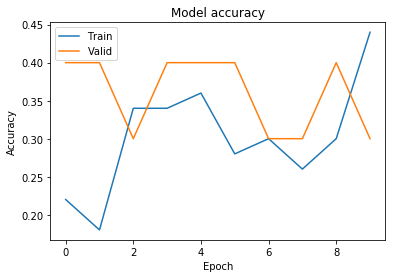

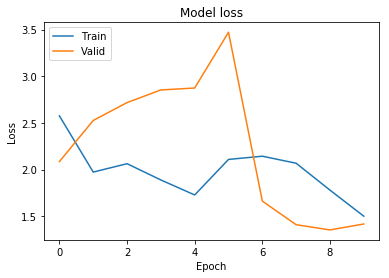

In [267]:
# Plot training & validation accuracy values
plt.plot(model_complete.history['acc'])
plt.plot(model_complete.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_complete.history['loss'])
plt.plot(model_complete.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

Evaluate test generator to get model accuracy

In [268]:
new_model.evaluate_generator(test_generator, verbose=1)

1/1 [==============================] - 3s 3s/step


[2.015547513961792, 0.10000000149011612]

Predict on test pictures

In [269]:
pred = new_model.predict_generator(test_generator, verbose=1)

1/1 [==============================] - 3s 3s/step


Retrieve dictionnary of classes of test set

In [280]:
test_map = dict((v, k.split("-")[1]) for k, v in test_generator.class_indices.items())
test_map

{0: 'Rhodesian_ridgeback',
 1: 'Scotch_terrier',
 2: 'French_bulldog',
 3: 'Great_Dane',
 4: 'Eskimo_dog'}

Get max proba for each picture (most probable class i.e. dog's breed)

The following accuracy is not to be trusted as representative of the model because 

In [281]:
# get max proba
max_preds = pred.argmax(axis=1)
print(max_preds)
# convert to dataframe
pred_df = pd.DataFrame(max_preds, columns=['pred_label'])
pred_df['pred_name'] = pred_df.pred_label.apply(lambda x: test_map[x])
pred_df['true_name'] = test_pictures_breeds
pred_df['true_id'] = pred_df.true_name.apply(lambda x: reverse_breed_dict[x])

# pred_df['true_id'] = target_names
# pred_df['true_name'] = pred_df.true_id.apply(lambda x: breed_dict[x])
# pred_df['true_label'] = pred_df.true_name.apply(lambda x: label_breed_dict[x])
pred_df['true_label'] = pred_df.true_name.apply(lambda x: subfold_enc.transform([x])[0])
pred_df['accurate'] = pd.Series([True if predict == truth else False for predict, truth in pred_df.loc[:, ['pred_label', 'true_label']].values])

[1 1 0 0 0 0 0 0 4 0]


In [282]:
pred_df

,pred_label,pred_name,true_name,true_id,true_label,accurate
0,1,Scotch_terrier,Rhodesian_ridgeback,n02087394,3,False
1,1,Scotch_terrier,Rhodesian_ridgeback,n02087394,3,False
2,0,Rhodesian_ridgeback,Scotch_terrier,n02097298,4,False
3,0,Rhodesian_ridgeback,Scotch_terrier,n02097298,4,False
4,0,Rhodesian_ridgeback,French_bulldog,n02108915,1,False
5,0,Rhodesian_ridgeback,French_bulldog,n02108915,1,False
6,0,Rhodesian_ridgeback,Great_Dane,n02109047,2,False
7,0,Rhodesian_ridgeback,Great_Dane,n02109047,2,False
8,4,Eskimo_dog,Eskimo_dog,n02109961,0,False
9,0,Rhodesian_ridgeback,Eskimo_dog,n02109961,0,True


Get accuracy

In [283]:
metrics.accuracy_score(pred_df.true_label, pred_df.pred_label)

0.1